<a href="https://colab.research.google.com/github/willhorgalcon/publicrep/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip -oq X.zip
!unzip -oq y.zip

In [2]:
import os
input_dir = "X"
target_dir = "y"
input_img_paths = sorted( [os.path.join(input_dir, fname) for fname in os.listdir(input_dir)
  if fname.endswith(".bmp")])
target_paths = sorted( [os.path.join(target_dir, fname) for fname in os.listdir(target_dir)
 if fname.endswith(".bmp") and not fname.startswith(".")])


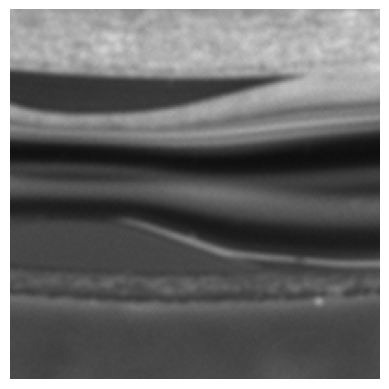

In [3]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

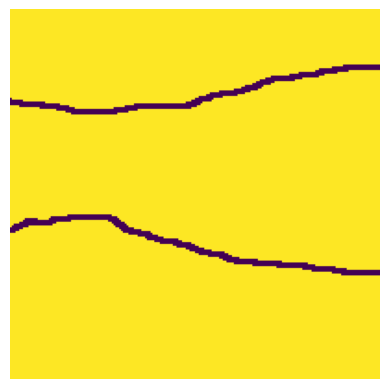

In [4]:
def display_target(target_array):
 normalized_array = (target_array.astype("uint8") - 1) * 127
 plt.axis("off")
 plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)



In [5]:
import numpy as np
import random

img_size = (100, 100)
num_imgs = len(input_img_paths)
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
 return img_to_array(load_img(path, target_size=img_size))
def path_to_target(path):
 img = img_to_array(
 load_img(path, target_size=img_size, color_mode="grayscale"))
 img = img.astype("uint8") - 1
 return img
input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="float32")
for i in range(num_imgs):
  input_imgs[i] = path_to_input_image(input_img_paths[i])
  targets[i] = path_to_target(target_paths[i])
targets /= 255
num_val_samples = 25
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [6]:
targets[10]

array([[[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       ...,

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]],

       [[1.],
        [1.],
        [1.],
        ...,
        [1.],
        [1.],
        [1.]]], dtype=float32)

In [39]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
 [
 layers.RandomFlip("horizontal"),
 layers.RandomRotation(0.1),
 layers.RandomZoom(0.2),
 ]
)

def get_model(img_size, num_classes):
 inputs = keras.Input(shape=img_size + (3,))
 x = data_augmentation(inputs)
 x = layers.Rescaling(1./255)(x)
 x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
 x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
 x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
 x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
 x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
 x = layers.Conv2DTranspose(
 64, 3, activation="relu", padding="same", strides=2)(x)
 outputs = layers.Conv2D(num_classes, 3, activation="sigmoid",
padding="same")(x)
 model = keras.Model(inputs, outputs)
 return model
model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 100, 100, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 50, 50, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 50, 50, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 25, 25, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 50, 50, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 50, 50, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_7 (Conv2DTranspose) │ (None, 100, 100, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 100, 100, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 667,779 (2.55 MB)

 Trainable params: 667,779 (2.55 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")
callbacks = [
 keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
 save_best_only=True)
]
history = model.fit(train_input_imgs, train_targets,
 epochs=30,
 callbacks=callbacks,
 batch_size=10,
 validation_data=(val_input_imgs, val_targets))

Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 0.9739 - val_loss: 0.2803
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2377 - val_loss: 0.2100
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2323 - val_loss: 0.2402
Epoch 4/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2114 - val_loss: 0.3121
Epoch 5/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.2753 - val_loss: 0.1896
Epoch 6/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.1884 - val_loss: 0.2615
Epoch 7/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.2323 - val_loss: 0.1836
Epoch 8/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1993 - val_loss: 0.1973
Epoch 9/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.1930 - val_loss: 0.1819
Epoch 10/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.1803 - val_loss: 0.1890
Epoch 11/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1789 - val_loss: 0.1715
Epoch 12/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1734 - val_loss: 0.1845


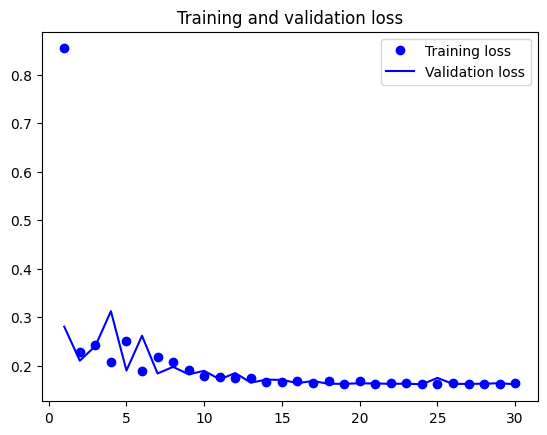

<Figure size 640x480 with 0 Axes>

In [41]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.figure()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


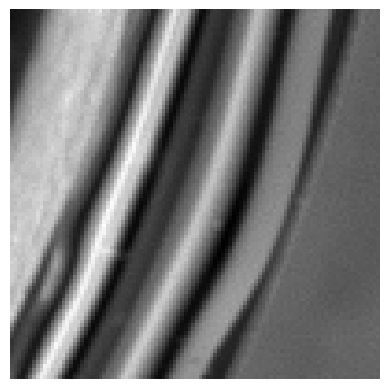

In [42]:
from tensorflow.keras.utils import array_to_img

i = 11
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]


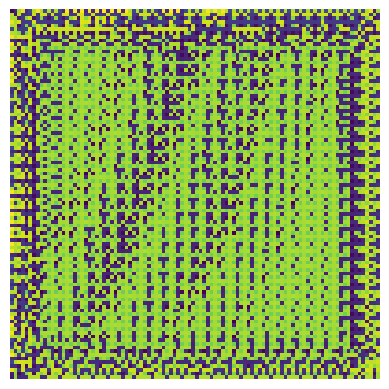

In [43]:
def display_mask(pred):
 mask = np.argmax(pred, axis=-1)
 mask *= 127
 plt.axis("off")
 plt.imshow(mask)


mask  *=255

display_target(mask)